In [ ]:
# !pip install OnClass==1.2
# !pip install matplotlib-venn

In [ ]:
import base64, json, sys, re, os, pandas as pd
from requests import get
from pprint import pprint


# Add code to read ASCTB config-sheet from CCF-reporter repo
# Parse the google sheet to create asctb dataframe

def get_ccf_reporter_sheet_config(verbose=False):
    """Accesses the Github repo for CCF-reporter, pulls the sheet-config at below URL.
    `https://github.com/hubmapconsortium/ccf-asct-reporter/blob/main/projects/v2/src/assets/sheet-config.json`
    
    This sheet contains links for all ASCT+B organs --> dataset URL.

    Args:
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    
    Return:
        list(dict): Python version of the `sheet_config.json` file.
    """
    USER = 'hubmapconsortium'
    REPOSITORY_NAME = 'ccf-asct-reporter'
    FILE_PATH = '/projects/v2/src/assets/sheet-config.json'
    sheet_config = None
    response = get(url=f'https://api.github.com/repos/{USER}/{REPOSITORY_NAME}/contents/{FILE_PATH}')
    if response.status_code == 200:
        json_response = response.json()
        decoded_content = base64.b64decode(json_response['content']) # Github returns response in b64 encoding
        json_string = decoded_content.decode('utf-8')
        sheet_config = json.loads(json_string)
    else:
        print(f'Error {response.status_code}! Something went wrong while trying to read the CCF-Reporter Github repo sheet-config file...')
    if verbose:  print(f'sheet_config = \n{sheet_config}')
    return sheet_config


def get_asctb_data_url(asctb_organ='Lung', asctb_organ_version='v1.1', verbose=False):
    """Reads the sheet-config from the CCF-reporter Github repo, and parses it to fetch the dataset-link for the specific organ and version.

    Args:
        asctb_organ (str, optional): Defaults to 'Lung'.
        asctb_organ_version (str, optional): Defaults to 'v1.1'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        str: URL for the specific ASCT+B organ and version.
    """
    GOOGLE_SHEETS_BASE_URL = 'https://docs.google.com/spreadsheets/d/'
    SHEET_CONFIG = get_ccf_reporter_sheet_config(verbose=verbose)
    if not SHEET_CONFIG:
        sys.exit('Couldnt access the CCF-Reporter Github!')

    for asctb_dataset in SHEET_CONFIG:
        if asctb_dataset['name'].lower() == asctb_organ.lower():
            if verbose:  pprint(asctb_dataset)
            for version_metadata in asctb_dataset['version']:
                if version_metadata['viewValue'] == asctb_organ_version:
                    version_name = version_metadata['value']
                    google_sheets_url = GOOGLE_SHEETS_BASE_URL + version_metadata['sheetId']
                    if verbose:  print(version_name, google_sheets_url)
                    return google_sheets_url
    return None

    


def fetch_ct_info_from_asctb_google_sheet(asctb_organ='Lung', asctb_organ_version='v1.1', filepath='Ontology_embeddings/', filename='ASCTB_Lungv1_2.csv', verbose=False):
    """Fetch and parse the ASCT+B dataset for the specific organ and version.
    
    Creates an ASCTB dataframe from the tuple-wise 3 columns like `[CT/1/ID, CT/1, CT/1/LABEL], [CT/2/ID, CT/2, CT/2/LABEL], ...`
    
    Returns a 3-column dataframe of `['CT_NAME', 'CT_ID', 'CT_LABEL']`.

    Args:
        asctb_organ (str, optional): Defaults to 'Lung'.
        asctb_organ_version (str, optional): Defaults to 'v1.1'.
        filepath (str, optional): Target file directory. Defaults to 'Ontology_embeddings/'.
        filename (str, optional): Target file name that'll contain the ASCTB NLP embeddings. Defaults to 'ASCTB_Lungv1_2.csv'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        pd.DataFrame: 3-column dataframe of `['CT_NAME', 'CT_ID', 'CT_LABEL']`.
    """

    GOOGLE_SHEET_URL = get_asctb_data_url(asctb_organ=asctb_organ, asctb_organ_version=asctb_organ_version, verbose=verbose)
    if not GOOGLE_SHEET_URL:
        sys.exit(f'Could not fetch the Google-Sheet URL for {asctb_organ} {asctb_organ_version}...')
    asctb_df = pd.read_csv(f'{GOOGLE_SHEET_URL}/export?format=csv', skiprows=10)

    regex_ctid = '^CT/[0-9]*/ID$'
    regex_ctname = '^CT/[0-9]*$'
    regex_ctlabel = '^CT/[0-9]/LABEL$'
    celltype_columns = sorted([col for col in asctb_df.columns if re.match(f'{regex_ctid}|{regex_ctlabel}|{regex_ctname}', col)])
    asctb_df = asctb_df[celltype_columns]

    raw_asctb_map_df = pd.DataFrame(columns=['CT_NAME', 'CT_ID', 'CT_LABEL'])
    for i in range(0, len(celltype_columns), 3):
        next_hierarchy_df = asctb_df[celltype_columns[i:i+3]]
        if verbose:  print(f'next_hierarchy_df={next_hierarchy_df.shape}')
        next_hierarchy_df.columns = raw_asctb_map_df.columns
        next_hierarchy_df = next_hierarchy_df.dropna(how='all')
        if verbose:  print(f'After dropping null rows, next_hierarchy_df={next_hierarchy_df.shape}')
        raw_asctb_map_df = pd.concat([ raw_asctb_map_df,  next_hierarchy_df ], axis=0)

    raw_asctb_map_df = raw_asctb_map_df.drop_duplicates()
    raw_asctb_map_df = raw_asctb_map_df[['CT_ID', 'CT_NAME', 'CT_LABEL']]
    raw_asctb_map_df.loc[raw_asctb_map_df['CT_ID'].isna(), 'CT_ID'] = 'ASCTB CT_ID UNK'

    os.makedirs(filepath, exist_ok=True)
    raw_asctb_map_df.to_csv(filepath+filename, index=False)

    return raw_asctb_map_df





def get_ontobee_response(cell_ontology_id='CL_0002062', verbose=False):
    """Reusable simple function to invoke the Ontobee API and fetch metadata about a specific CT-ID.

    Args:
        cell_ontology_id (str, optional): Defaults to 'CL_0002062'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        str: Response from API call.
    """
    cell_ontology_id = cell_ontology_id.replace(':', '_')
    ONTOBEE_BASE_URL = "http://www.ebi.ac.uk/ols/api/ontologies/cl/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2F"
    response = get(ONTOBEE_BASE_URL+cell_ontology_id, headers={'Accept':'application/json'}, data={})
    return response




def get_cell_ontology_definition_from_id(cell_ontology_id='CL_0002062', verbose=False):
    """Fetches Cell-Type definition of specific CT-ID from the Ontobee API.

    Args:
        cell_ontology_id (str, optional): CT-ID with ':' replaced by '_'. Defaults to 'CL_0002062'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    """
    definition = 'NaN'
    response = get_ontobee_response(cell_ontology_id)

    if response.status_code!=200:
        if verbose:  print(f'Something went wrong while using the Ontobee API for {cell_ontology_id}...')
    else:
        if verbose:  print(f'Found label for {cell_ontology_id}!')
        try:
            definition = response.json()['_embedded']['terms'][0]['annotation']['definition'][0]
        except Exception as e:
            if verbose:  print(f'Something went wrong while trying to access the definition of `{cell_ontology_id}`...{e}')

    if verbose:  print(f'{cell_ontology_id} has label={definition}')
    return definition




def fetch_asctb_definitions_cell_ontology(asctb_df=None, filename='ASCTB_Lungv1_2.csv'):
    """Reads the ASCT+B source-file if input dataframe is empty, and fetches the description metadata from Cell-Ontology.
    Merge the description with current text-data in ASCT+B, so that we can generate more informative encodings.

    > Ideally this file should contain the entire ASCTB CT-ID vs CT-text information.

    Args:
        asctb_df (pd.DataFrame): Dataframe of ASCTB parsed 3 columns `['CT_NAME', 'CT_ID', 'CT_LABEL']`. Defaults to None.
        filename (str, optional): Defaults to 'ASCTB_Lungv1_2.csv'.

    Returns:
        pd.DataFrame: DataFrame of ASCT+B data merged with Cell-Ontology definitions of Cell-Types.
    """
    if asctb_df.empty or asctb_df.shape[0]==0:
        asctb_df = pd.read_csv(filename)
    asctb_df['definition'] = asctb_df['CT_ID'].str.replace(':','_').apply(get_cell_ontology_definition_from_id)
    asctb_df['all_text'] = asctb_df['CT_NAME'] + ' ' + asctb_df['CT_LABEL'] + ' ' + asctb_df['definition']
    asctb_df.loc[asctb_df['all_text'].isna(), 'all_text'] = asctb_df.loc[asctb_df['all_text'].isna(), 'CT_NAME']
    asctb_df = asctb_df.reset_index(drop=True)
    asctb_df.to_csv(filename, index=False, encoding='utf-8-sig')
    return asctb_df






VERBOSE = False
ASCTB_ORGAN = 'Lung'
ASCTB_VERSION = 'v1.2'
FILEPATH = 'ontology_embeddings/'
FILENAME = f'ASCTB_{ASCTB_ORGAN}{ASCTB_VERSION.replace(".","_")}.csv'

raw_asctb_map_df = fetch_ct_info_from_asctb_google_sheet(
    asctb_organ=ASCTB_ORGAN, asctb_organ_version=ASCTB_VERSION, 
    filepath=FILEPATH, filename=FILENAME, verbose=VERBOSE
)

asctb_embeddings_df = fetch_asctb_definitions_cell_ontology(
    asctb_df=raw_asctb_map_df, 
    filename=FILEPATH+FILENAME
)
asctb_embeddings_df

In [ ]:
import string, contractions, re
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

from num2words import num2words
from textacy import extract
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity




def remove_whitespaces(word):
    return word.replace(' ', '')

def expand_word_contractions(word):
    return contractions.fix(word)

def replace_special_chars(word):
    return re.sub('[^a-zA-Z0-9]*', '', word)

def convert_number_to_word(word):
    return num2words(word) if word.isdigit() else word

def make_lowercase(word):
    return word.lower()

def get_root_word(word):
    l = WordNetLemmatizer()
    return l.lemmatize(word)

def is_not_stopword(word):
    return word not in set(stopwords.words('english')) and word!='NaN' 


def execute_nlp_pipeline(word):
    PIPELINE_STEPS = [
        remove_whitespaces,
        expand_word_contractions,
        replace_special_chars,
        convert_number_to_word,
        make_lowercase,
        get_root_word
    ]
    for i, func in enumerate(PIPELINE_STEPS):
        word = func(word)
    return word




def get_asctb_embedding(row, sentence_encoding_model, verbose=False):
    """Performs basic NLP preprocessing tasks with stopwords removed, and returns an embedding of the unique sentence produced.

    Args:
        sentence_encoding_model (SentenceTransformer): Sentence encoder that transforms input cleaned sentence into 768 dimensions.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        np.ndarray: 768x1 EMBEDDING
    """
    ct_id = row['CT_ID']
    ct_label = row['CT_NAME']
    asctb_all_text = row['all_text']
    if verbose:  print(f'CT-ID={ct_id}, CT-LABEL={ct_label}, all_text={asctb_all_text}')
    all_text = []
    unique_words = set()

    for word in asctb_all_text.split(' '):
        cleaned_word = execute_nlp_pipeline(word)
        if verbose:  print(word, cleaned_word)
        if cleaned_word not in unique_words and is_not_stopword(word):
            all_text.append(cleaned_word)
            if verbose:  print(f'All-Text = {all_text}')
            unique_words.add(cleaned_word)
    embedding = sentence_encoding_model.encode(' '.join(all_text))
    return embedding




sentence_encoding_model = SentenceTransformer('all-mpnet-base-v2')
asctb_embeddings_df['embedding_results'] = asctb_embeddings_df.apply(
    get_asctb_embedding, 
    axis=1, 
    sentence_encoding_model=sentence_encoding_model, 
    verbose=False
)
asctb_embeddings_df.to_csv(FILEPATH+FILENAME, index=False, encoding='utf-8-sig')
asctb_embeddings_df

In [ ]:
import numpy as np
import sys
import pandas as pd
from anndata import read_h5ad





def clean_input_labels(raw_labels):
    """Removes punctuation marks from input CT-label and lemmatizes the word to it's root word.

    Args:
        raw_labels (np.array): Array of raw input CT-labels.

    Returns:
        np.array: Array of cleaned and lemmatized CT-labels.
    """
    cleaned_labels = []
    l = WordNetLemmatizer()
    for ctlabel in raw_labels:
        cleaned_ctlabel = ctlabel.translate(str.maketrans('', '', string.punctuation))
        cleaned_labels.append(' '.join([l.lemmatize(word) for word in cleaned_ctlabel.split(' ')]))
    return np.array(cleaned_labels)


def get_cell_ontology_label_from_id(cell_ontology_id='CL_0002062', verbose=False):
    """Adds a new column with cleaned CT_ID string, and fetches Label from the Ontobee API.

    Args:
        cell_ontology_id (str, optional): CT-ID with ':' replaced by '_'. Defaults to 'CL_0002062'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.
    """
    label = 'NaN'
    response = get_ontobee_response(cell_ontology_id)

    if response.status_code!=200:
        if verbose:  print(f'Something went wrong while using the Ontobee API for {cell_ontology_id}...')
    else:
        if verbose:  print(f'Found label for {cell_ontology_id}!')
        label = response.json()['_embedded']['terms'][0]['label']
    if verbose:  print(f'{cell_ontology_id} has label={label}')
    return label




def fetch_cell_ontology_labels(raw_to_cl_labels, cell_ontology_ids, indexes, source='PopV'):
    """Creates a new dataframe of `[OnClass.CT_IDs] Left-join [Raw.Labels]` based on Index matches.
    Creates a new column of CT-ID with ':' replaced by '_', and then fetches CT-labels from Ontobee for each CT-ID.
    Derives a column to check if exact-match for inputLabel <-> cellOntologyLabel.
    Writes the df to a `PopVLabels_to_CellOntologyLabels.csv`.

    Args:
        labels (pd.DataFrame): Dataframe of Source CT-labels from Model (PopV/CellTypist/Azimuth/FR-match), and their cleaned version that was used as input for `OnClass`.
        cell_ontology_ids (np.array): CT-IDs derived from `OnClass.map_and_select_labels()`
        indexes (np.array): Integer indexes derived from `OnClass.map_and_select_labels()`
        source (str, optional): Source-Model that generated these source-labels (PopV/CellTypist/Azimuth/FR-match). Defaults to 'PopV'.

    Returns:
        pd.DataFrame: Reported dataframe with ['source_labels', 'cell_ontology_id', 'cell_ontology_label', 'exact_match']
    """
    # Create dataframe, left-join of raw-labels with derived CT-IDs
    cl_labels_df = pd.DataFrame({'cell_ontology_id':cell_ontology_ids}, index=indexes)
    raw_to_cl_labels = raw_to_cl_labels.join(cl_labels_df, how='left')

    # Create new column of CT-ID with ':' replaced by '_'
    raw_to_cl_labels['cell_ontology_label'] = raw_to_cl_labels['cell_ontology_id'].str.replace(':','_')
    
    # Fetches CT-labels from Ontobee for each CT-ID where CT-ID is not null
    raw_to_cl_labels.loc[~raw_to_cl_labels['cell_ontology_id'].isna(), 'cell_ontology_label'] = raw_to_cl_labels.loc[~raw_to_cl_labels['cell_ontology_id'].isna(), 'cell_ontology_label'].apply(get_cell_ontology_label_from_id)
    raw_to_cl_labels['cell_ontology_label'] = raw_to_cl_labels['cell_ontology_label'].str.lower()

    # Derived column to check if raw-label matches with best-matching label exactly
    raw_to_cl_labels['exact_match_found_in_cell_ontology'] = raw_to_cl_labels['cell_ontology_label'].str.lower() == raw_to_cl_labels[f'cleaned_input_label'].str.lower()
    raw_to_cl_labels.to_csv(f'{source}Labels_to_CellOntologyLabels.csv', index=False, encoding='utf-8-sig')
    return raw_to_cl_labels





def get_best_asctb_label_match(sentence_encoding_model, asctb_embeddings_df, input_label='adventitial fibroblasts', verbose=False):
    """Performs basic NLP preprocessing to the input label, and chooses ASCT+B match based upon cosine-similarity.
    The Embeddings Dataframe needs to be precomputed with an 'embeddings_results' column containing np.ndarrays of 768x1 dimensions.

    Args:
        sentence_encoding_model (SentenceTransformer): Sentence encoder that transforms input cleaned sentence into 768 dimensions.
        asctb_embeddings_df (pd.DataFrame): Dataframe containing an 'embeddings_results' column containing precomputed np.ndarrays of 768x1 dimensions.
        input_label (str, optional): Defaults to 'adventitial fibroblasts'.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        str, float, str, str: Cleaned input CT-label, and best-matching ASCT+B information found for input CT-label.
    """
    cleaned_input_label = ' '.join([execute_nlp_pipeline(word) for word in input_label.split()])
    input_embedding = sentence_encoding_model.encode(cleaned_input_label)
    reference_embeddings = np.row_stack(asctb_embeddings_df['embedding_results'])
    if verbose:  print(f'Trying to match `{input_label}` with reference_embeddings={reference_embeddings.shape}\n{reference_embeddings}')
    cosine_similarities = cosine_similarity(
        reference_embeddings , 
        input_embedding.reshape(1,-1)
    )
    if verbose:  print(f'cosine_similarities={cosine_similarities.shape}\n{cosine_similarities}')
    best_match_index = np.argmax(cosine_similarities)
    cosine_sim_match_score = np.max(cosine_similarities)
    best_match_ct_id = asctb_embeddings_df.loc[best_match_index, 'CT_ID']
    best_match_ct_label = asctb_embeddings_df.loc[best_match_index, 'CT_NAME']
    
    if verbose:  print(f'input_label={input_label}, cosine_similarities={cosine_similarities.shape}, Cosine-Similarity={np.max(cosine_similarities)}, best_match_index={best_match_index}, Match-Found=[{best_match_ct_id} , {best_match_ct_label}]')
    return cleaned_input_label, cosine_sim_match_score, best_match_ct_id, best_match_ct_label


def map_raw_labels_to_asctb(raw_labels, source_name='ASCT+B', verbose=False):
    """Main function to map all input raw-labels to a standard controlled vocabulary maintained by `ASCT+B`.
    Entire df containing information on cleaned-input-label, matched ASCTB label, cosine-similarity score, etc.

    Args:
        raw_labels (iterable): A list/np.array/set of raw-input labels that need to mapped against `ASCT+B`.
        source_name (str): Source name like CellTypist/Azimuth/PopV. Defaults to `ASCT+B`.
        verbose (bool, optional): Flag to indicate logging in verbose mode. Defaults to False.

    Returns:
        pd.DataFrame: Columns include cosine-similary: `match_score`, matched CT-ID: `matched_asctb_id`, matched CT-LABEL: `matched_asctb_label`, etc.
    """
    if verbose:  print(f'Standardizing {len(raw_labels)} labels...')
    tgt_folder = 'data/'
    tgt_filename = f'{source_name}Labels_to_ASCTBLabels.csv'
    tgt_filepath = f'{tgt_folder}{tgt_filename}'
    raw_to_asctb_labels_df = pd.DataFrame({
        'source':source_name, 
        'raw_input_label':raw_labels
    })
    for input_label in raw_labels:
            cleaned_input_label, cosine_sim_match_score, best_match_ct_id, best_match_ct_label = get_best_asctb_label_match(
                sentence_encoding_model, 
                asctb_embeddings_df, 
                input_label=input_label,
                verbose=True
            )
            raw_to_asctb_labels_df.loc[raw_to_asctb_labels_df['raw_input_label']==input_label, 'cleaned_input_label'] = cleaned_input_label
            raw_to_asctb_labels_df.loc[raw_to_asctb_labels_df['raw_input_label']==input_label, 'match_score'] = cosine_sim_match_score
            raw_to_asctb_labels_df.loc[raw_to_asctb_labels_df['raw_input_label']==input_label, 'matched_asctb_id'] = best_match_ct_id
            raw_to_asctb_labels_df.loc[raw_to_asctb_labels_df['raw_input_label']==input_label, 'matched_asctb_label'] = best_match_ct_label
    raw_to_asctb_labels_df['exact_match_found_in_asctb'] = raw_to_asctb_labels_df['cleaned_input_label'].str.lower() == raw_to_asctb_labels_df[f'matched_asctb_label'].str.lower()
    if verbose:  print(f'Mapped all labels to ASCT+B. Now writing the dataframe at {tgt_filepath}')
    try:
        raw_to_asctb_labels_df.to_csv(tgt_filepath, index=False, encoding='utf-8-sig')
    except Exception as e:
        print(f'Something went wrong while trying to write the translations to a CSV file: {e}')
    return raw_to_asctb_labels_df



celltypist_labels = np.array([
    'adventitial fibroblasts',	'alveolar fibroblasts',	'alveolar macrophages',	'alveolar mï† ccl3+',	'alveolar mï† mt-positive',	
    'alveolar mï† proliferating',	'at1',	'at2',	'at2 proliferating',	'b cells',	'basal resting',	'cd4 t cells',	
    'cd8 t cells',	'classical monocytes',	'club (nasal)',	'club (non-nasal)',	'dc1',	'dc2',	'deuterosomal',	'ec aerocyte capillary',	'ec arterial',	
    'ec general capillary',	'ec venous pulmonary',	'ec venous systemic',	'fibromyocytes',	'goblet (bronchial)',	'goblet (nasal)',	
    'goblet (subsegmental)',	'interstitial mï† perivascular',	'ionocyte',	'lymphatic ec differentiating',	'lymphatic ec mature',	
    'lymphatic ec proliferating',	'mast cells',	'mesothelium',	'migratory dcs',	'monocyte-derived mï†',	'multiciliated (nasal)',	
    'multiciliated (non-nasal)',	'myofibroblasts',	'neuroendocrine',	'nk cells',	'non-classical monocytes',	'peribronchial fibroblasts',	
    'pericytes',	'plasma cells',	'plasmacytoid dcs',	'sm activated stress response',	'smg duct',	'smg mucous',	'smg serous (bronchial)',	'smg serous (nasal)',	
    'smooth muscle',	'subpleural fibroblasts',	'suprabasal',	't cells proliferating',	'transitional club-at2',	'tuft'
])


azimuth_labels = np.array([
    'adventitial fibroblasts',	'alveolar fibroblasts',	'alveolar macrophages',	'alveolar mï† proliferating',	'at1',	'at2',	'at2 proliferating',	
    'b cells',	'basal resting',	'cd4 t cells',	'cd8 t cells',	'classical monocytes',	'club (nasal)',	'club (non-nasal)',	'dc2',	'deuterosomal',	
    'ec aerocyte capillary',	'ec arterial',	'ec general capillary',	'ec venous pulmonary',	'ec venous systemic',	'goblet (nasal)',	
    'interstitial mï† perivascular',	'ionocyte',	'lymphatic ec differentiating',	'lymphatic ec mature',	'mast cells',	'monocyte-derived mï†',	
    'multiciliated (nasal)',	'multiciliated (non-nasal)',	'myofibroblasts',	'nk cells',	'non-classical monocytes',	'peribronchial fibroblasts',	
    'pericytes',	'plasma cells',	'plasmacytoid dcs',	'sm activated stress response',	'smg mucous',	'smooth muscle',	'suprabasal',	't cells proliferating',	
    'transitional club-at2',	'tuft'
])



popv_labels = np.array([
    'adventitial cell',	'alveolar fibroblast',	'b cell',	'basal cell',	'basophil',	
    'bronchial smooth muscle cell',	'bronchial vessel endothelial cell',	'capillary aerocyte',	
    'capillary endothelial cell',	'cd4-positive alpha-beta t cell',	'cd4-positive, alpha-beta t cell',	
    'cd8-positive alpha-beta t cell',	'cd8-positive, alpha-beta t cell',	'classical monocyte',	'club cell',	
    'dendritic cell',	'endothelial cell of artery',	'endothelial cell of lymphatic vessel',	'fibroblast',	
    'intermediate monocyte',	'lung ciliated cell',	'lung microvascular endothelial cell',	'macrophage',	
    'mesothelial cell',	'myofibroblast cell',	'neutrophil',	'nk cell',	'non-classical monocyte',	'pericyte cell',
    'plasma cell',	'plasmacytoid dendritic cell',	'pulmonary ionocyte',	'respiratory goblet cell',	
    'respiratory mucous cell',	'serous cell of epithelium of bronchus',	'smooth muscle cell',	'type i pneumocyte',
    'type ii pneumocyte',	'vascular associated smooth muscle cell',	'vein endothelial cell'
    ])


source_vs_labels_dict = {
    'CellTypist' : celltypist_labels,
    'Azimuth' : azimuth_labels, 
    'PopV' : popv_labels
}








ctlabels_translations_df = pd.DataFrame()

for SOURCE in source_vs_labels_dict:
    print(f'Standardizing labels for {SOURCE}')
    raw_to_asctb_labels = pd.DataFrame({'source':SOURCE, 'raw_input_label':source_vs_labels_dict[SOURCE]})
    '''
    ############## OLD CODE ##############
    raw_to_cl_labels['cleaned_input_label'] = clean_input_labels(source_vs_labels_dict[SOURCE])
    train_label = 'cell_ontology_id'
    test_label = 'cell_ontology_id'
    model_path = model_dir + 'example_file_model'
    cell_type_nlp_emb_file, cell_type_network_file, cl_obo_file = read_ontology_file(ontology_data_dir)
    co2co_graph, co2co_nlp, co2vec_nlp, cell_ontology_ids = read_cell_type_nlp_network(cell_type_nlp_emb_file, cell_type_network_file)
    print(f'{type(co2co_graph)}, {type(co2co_nlp)}, {type(co2vec_nlp)}, {type(cell_ontology_ids)}')
    indexes, cell_ontology_found_ids, unfound_labels = map_and_select_labels(
            raw_to_cl_labels['cleaned_input_label'], cell_ontology_ids, cl_obo_file, 
            ct_mapping_key={},
            nlp_mapping=True, 
            co2emb=co2vec_nlp, 
            nlp_mapping_cutoff=.6, 
            cl_obo_file=cl_obo_file
    )
    ctlabels_translations_df = pd.concat([
        ctlabels_translations_df,
        fetch_cell_ontology_labels(cell_ontology_ids=cell_ontology_found_ids, raw_to_cl_labels=raw_to_cl_labels, source=SOURCE, indexes=indexes)
    ])

try:
    ctlabels_translations_df.loc[ctlabels_translations_df['cell_ontology_label'].isna(), 'cell_ontology_label'] = ctlabels_translations_df.loc[ctlabels_translations_df['cell_ontology_label'].isna(), 'cleaned_input_label']
    ctlabels_translations_df.to_csv('CTlabels_translations.csv', index=False)
    ctlabels_translations_df.groupby(by=['source'])['cell_ontology_label'].apply(list).to_csv('Aggregated_CTlabels_translations.csv', encoding='utf-8-sig')
    print('Wrote the final translations-mapping file to csv!')
except Exception as e:
    print(f'Something went wrong while trying to write the csv: {e}')

    '''
    raw_to_asctb_labels_df = map_raw_labels_to_asctb(
        source_name=SOURCE,
        raw_labels=source_vs_labels_dict[SOURCE],
        verbose=VERBOSE
    )
    ctlabels_translations_df = pd.concat([
        ctlabels_translations_df,
        raw_to_asctb_labels_df
    ])

try:
    ctlabels_translations_df.loc[ctlabels_translations_df['matched_asctb_label'].isna(), 'matched_asctb_label'] = ctlabels_translations_df.loc[ctlabels_translations_df['matched_asctb_label'].isna(), 'cleaned_input_label']
    ctlabels_translations_df.to_csv('data/CTlabels_translations.csv', index=False)
    # ctlabels_translations_df.groupby(by=['source'])['matched_asctb_label'].apply(list).to_csv('Aggregated_CTlabels_translations.csv', encoding='utf-8-sig')
    print('Wrote the final translations-mapping files to csv!')
except Exception as e:
    print(f'Something went wrong while trying to write the csv: {e}')

# TESTING OUT VENN-DIAGRAMS IN PYTHON PLOTLY

In [ ]:
from collections import Counter
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt



def make_threeway_venn_diagram(A, B, C, labels):
    """General function to create a three-way Venn diagram.

    Args:
        A (set): Set of elements
        B (set): Set of elements
        C (set): Set of elements
        labels (list): Names/labels for A, B, C.
    """
    AB_overlap = A & B  #compute intersection of set A & set B
    AC_overlap = A & C
    BC_overlap = B & C
    ABC_overlap = A & B & C
    A_rest = A - AB_overlap - AC_overlap #see left graphic
    B_rest = B - AB_overlap - BC_overlap
    C_rest = C - AC_overlap - BC_overlap
    AB_only = AB_overlap - ABC_overlap   #see right graphic
    AC_only = AC_overlap - ABC_overlap
    BC_only = BC_overlap - ABC_overlap


    sets = Counter()               #set order A, B, C   
    sets['100'] = len(A_rest)      #100 denotes A on, B off, C off 
    sets['010'] = len(B_rest)      #010 denotes A off, B on, C off
    sets['001'] = len(C_rest)      #001 denotes A off, B off, C on 
    sets['110'] = len(AB_only)     #110 denotes A on, B on, C off
    sets['101'] = len(AC_only)     #101 denotes A on, B off, C on 
    sets['011'] = len(BC_only)     #011 denotes A off, B on, C on 
    sets['111'] = len(ABC_overlap) #011 denotes A on, B on, C on
    plt.figure(figsize=(7,7)) 
    ax = plt.gca() 
    colors = ['darkviolet','deepskyblue','blue']
    v = venn3(subsets=sets, set_labels=labels, ax=ax, set_colors=colors, alpha=0.7)   
    for i, text in enumerate(v.set_labels):
        text.set_color(colors[i])

    for text in v.subset_labels:
        if not text:
            continue
        text.set_color('white')
        text.set_fontsize(16)
        text.set_fontweight('bold')
    plt.savefig('data/threeway_intersection.png')
    plt.show()


all_combos = ctlabels_translations_df.groupby(by=['source'])['matched_asctb_label'].apply(set)
all_sets_list = all_combos.values.tolist()
all_labels = all_combos.index.tolist()
make_threeway_venn_diagram(
    A=all_sets_list[0],
    B=all_sets_list[1],
    C=all_sets_list[2],
    labels=(all_labels)
    )

# Let's create a package!

In [ ]:
import numpy as np, pandas as pd

from sentence_transformers import SentenceTransformer
from src.asctb_ct_label_mapper.main import fetch_asctb_reference_embeddings, map_raw_labels_to_asctb



VERBOSE = False
ASCTB_ORGAN = 'Lung'
ASCTB_VERSION = 'v1.2'
SENTENCE_ENCODING_MODEL = SentenceTransformer('all-mpnet-base-v2')
SOURCE = 'PopV'
RAW_LABELS = np.array([
    'adventitial cell',	'alveolar fibroblast',	'b cell',	'basal cell',	'basophil',	
    'bronchial smooth muscle cell',	'bronchial vessel endothelial cell',	'capillary aerocyte',	
    'capillary endothelial cell',	'cd4-positive alpha-beta t cell',	'cd4-positive, alpha-beta t cell',	
    'cd8-positive alpha-beta t cell',	'cd8-positive, alpha-beta t cell',	'classical monocyte',	'club cell',	
    'dendritic cell',	'endothelial cell of artery',	'endothelial cell of lymphatic vessel',	'fibroblast',	
    'intermediate monocyte',	'lung ciliated cell',	'lung microvascular endothelial cell',	'macrophage',	
    'mesothelial cell',	'myofibroblast cell',	'neutrophil',	'nk cell',	'non-classical monocyte',	'pericyte cell',
    'plasma cell',	'plasmacytoid dendritic cell',	'pulmonary ionocyte',	'respiratory goblet cell',	
    'respiratory mucous cell',	'serous cell of epithelium of bronchus',	'smooth muscle cell',	'type i pneumocyte',
    'type ii pneumocyte',	'vascular associated smooth muscle cell',	'vein endothelial cell'
    ])







asctb_embeddings_df = fetch_asctb_reference_embeddings(
    sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
    asctb_organ=ASCTB_ORGAN, 
    asctb_version=ASCTB_VERSION, 
    verbose=VERBOSE
)

raw_to_asctb_labels_df = map_raw_labels_to_asctb(
        source_name=SOURCE,
        raw_labels=RAW_LABELS,
        sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
        asctb_embeddings_df=asctb_embeddings_df,
        verbose=VERBOSE
    )
raw_to_asctb_labels_df

In [1]:
import numpy as np, pandas as pd

from sentence_transformers import SentenceTransformer
from src.asctb_ct_label_mapper.main import fetch_asctb_reference_embeddings, map_raw_labels_to_asctb
from src.asctb_ct_label_mapper.utilities.nlp_preprocessing import download_nlp_models




VERBOSE = False
ASCTB_ORGAN = 'Lung'
ASCTB_VERSION = 'v1.2'
SENTENCE_ENCODING_MODEL = SentenceTransformer('all-mpnet-base-v2')


celltypist_labels = np.array([
    'adventitial fibroblasts',	'alveolar fibroblasts',	'alveolar macrophages',	'alveolar mï† ccl3+',	'alveolar mï† mt-positive',	
    'alveolar mï† proliferating',	'at1',	'at2',	'at2 proliferating',	'b cells',	'basal resting',	'cd4 t cells',	
    'cd8 t cells',	'classical monocytes',	'club (nasal)',	'club (non-nasal)',	'dc1',	'dc2',	'deuterosomal',	'ec aerocyte capillary',	'ec arterial',	
    'ec general capillary',	'ec venous pulmonary',	'ec venous systemic',	'fibromyocytes',	'goblet (bronchial)',	'goblet (nasal)',	
    'goblet (subsegmental)',	'interstitial mï† perivascular',	'ionocyte',	'lymphatic ec differentiating',	'lymphatic ec mature',	
    'lymphatic ec proliferating',	'mast cells',	'mesothelium',	'migratory dcs',	'monocyte-derived mï†',	'multiciliated (nasal)',	
    'multiciliated (non-nasal)',	'myofibroblasts',	'neuroendocrine',	'nk cells',	'non-classical monocytes',	'peribronchial fibroblasts',	
    'pericytes',	'plasma cells',	'plasmacytoid dcs',	'sm activated stress response',	'smg duct',	'smg mucous',	'smg serous (bronchial)',	'smg serous (nasal)',	
    'smooth muscle',	'subpleural fibroblasts',	'suprabasal',	't cells proliferating',	'transitional club-at2',	'tuft'
])


azimuth_labels = np.array([
    'adventitial fibroblasts',	'alveolar fibroblasts',	'alveolar macrophages',	'alveolar mï† proliferating',	'at1',	'at2',	'at2 proliferating',	
    'b cells',	'basal resting',	'cd4 t cells',	'cd8 t cells',	'classical monocytes',	'club (nasal)',	'club (non-nasal)',	'dc2',	'deuterosomal',	
    'ec aerocyte capillary',	'ec arterial',	'ec general capillary',	'ec venous pulmonary',	'ec venous systemic',	'goblet (nasal)',	
    'interstitial mï† perivascular',	'ionocyte',	'lymphatic ec differentiating',	'lymphatic ec mature',	'mast cells',	'monocyte-derived mï†',	
    'multiciliated (nasal)',	'multiciliated (non-nasal)',	'myofibroblasts',	'nk cells',	'non-classical monocytes',	'peribronchial fibroblasts',	
    'pericytes',	'plasma cells',	'plasmacytoid dcs',	'sm activated stress response',	'smg mucous',	'smooth muscle',	'suprabasal',	't cells proliferating',	
    'transitional club-at2',	'tuft'
])



popv_labels = np.array([
    'adventitial cell',	'alveolar fibroblast',	'b cell',	'basal cell',	'basophil',	
    'bronchial smooth muscle cell',	'bronchial vessel endothelial cell',	'capillary aerocyte',	
    'capillary endothelial cell',	'cd4-positive alpha-beta t cell',	'cd4-positive, alpha-beta t cell',	
    'cd8-positive alpha-beta t cell',	'cd8-positive, alpha-beta t cell',	'classical monocyte',	'club cell',	
    'dendritic cell',	'endothelial cell of artery',	'endothelial cell of lymphatic vessel',	'fibroblast',	
    'intermediate monocyte',	'lung ciliated cell',	'lung microvascular endothelial cell',	'macrophage',	
    'mesothelial cell',	'myofibroblast cell',	'neutrophil',	'nk cell',	'non-classical monocyte',	'pericyte cell',
    'plasma cell',	'plasmacytoid dendritic cell',	'pulmonary ionocyte',	'respiratory goblet cell',	
    'respiratory mucous cell',	'serous cell of epithelium of bronchus',	'smooth muscle cell',	'type i pneumocyte',
    'type ii pneumocyte',	'vascular associated smooth muscle cell',	'vein endothelial cell'
    ])


source_vs_labels_dict = {
    'CellTypist' : celltypist_labels,
    'Azimuth' : azimuth_labels, 
    'PopV' : popv_labels
}



ctlabels_translations_df = pd.DataFrame()
download_nlp_models()

asctb_embeddings_df = fetch_asctb_reference_embeddings(
    sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
    asctb_organ=ASCTB_ORGAN, 
    asctb_version=ASCTB_VERSION, 
    verbose=VERBOSE
)


for SOURCE, RAW_LABELS in source_vs_labels_dict.items():
    print(f'Standardizing labels for {SOURCE}')
    raw_to_asctb_labels_df = map_raw_labels_to_asctb(
        source_name=SOURCE,
        raw_labels=RAW_LABELS,
        sentence_encoding_model=SENTENCE_ENCODING_MODEL, 
        asctb_embeddings_df=asctb_embeddings_df,
        verbose=VERBOSE
    )

    ctlabels_translations_df = pd.concat([
        ctlabels_translations_df,
        raw_to_asctb_labels_df
    ])

try:
    ctlabels_translations_df.loc[ctlabels_translations_df['matched_asctb_label'].isna(), 'matched_asctb_label'] = ctlabels_translations_df.loc[ctlabels_translations_df['matched_asctb_label'].isna(), 'cleaned_input_label']
    ctlabels_translations_df.to_csv('data/All_CTlabels_translations.csv', index=False)
    print('Wrote the final translations-mapping files to csv!')
except Exception as e:
    print(f'Something went wrong while trying to write the csv: {e}')

Found pre-computed embeddings at ontology_embeddings/ASCTB_Lungv1_2.pkl. Using these again!
Standardizing labels for CellTypist
Standardizing labels for Azimuth
Standardizing labels for PopV
Wrote the final translations-mapping files to csv!


<Figure size 432x288 with 0 Axes>

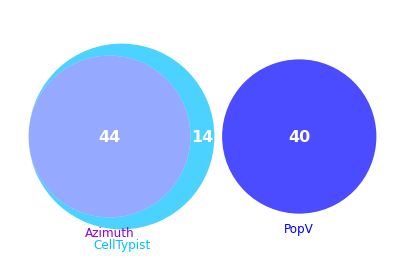

In [2]:
from src.asctb_ct_label_mapper.utilities.plotting import make_threeway_venn_diagram


all_combos = ctlabels_translations_df.groupby(by=['source'])['raw_input_label'].apply(set)
all_sets_list = all_combos.values.tolist()
all_labels = all_combos.index.tolist()
_ = make_threeway_venn_diagram(
    A=all_sets_list[0],
    B=all_sets_list[1],
    C=all_sets_list[2],
    labels=(all_labels),
    title='Before'
    )

<Figure size 432x288 with 0 Axes>

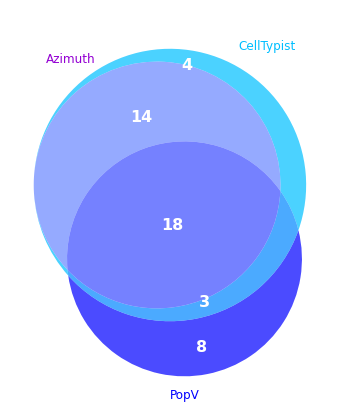

In [3]:
from src.asctb_ct_label_mapper.utilities.plotting import make_threeway_venn_diagram



all_combos = ctlabels_translations_df.groupby(by=['source'])['matched_asctb_label'].apply(set)
all_sets_list = all_combos.values.tolist()
all_labels = all_combos.index.tolist()
_ = make_threeway_venn_diagram(
    A=all_sets_list[0],
    B=all_sets_list[1],
    C=all_sets_list[2],
    labels=(all_labels),
    title='After'
    )